# Trading Strategies

# Trading signals

## What are trading signals?
First, let's discuss trading signals. Trading signals are **triggers** to long (buy) or short (sell) financial assets based on predetermined criteria. They can be constructed using one technical indicator, multiple technical indicators, or a combination of market data and indicators. Trading signals are commonly used in algorithmic trading, where trading strategies make decisions based on quantitative rules, and remove human discretion.

## A signal example
Here is an example of a simple signal. It is constructed by comparing the price with its n-period simple moving average, or SMA. A long signal is triggered to buy the asset when its price rises above the SMA, and exit the long trade when its price drops below the SMA.

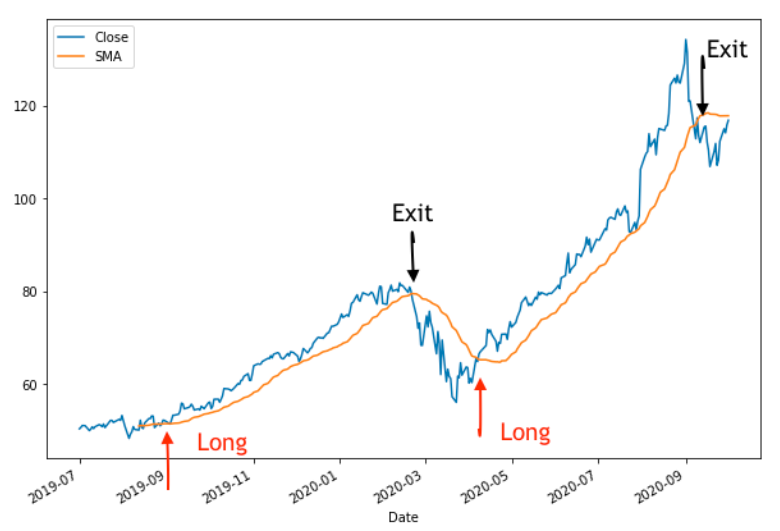

## How to implement signals in bt
Previously (chapter 1), we discussed the 4-step process of defining and backtest trading strategies, and in particular, how bt uses individual algos as building blocks to handle trading logic. 

4-step process:
1. Get the data and calculate indicators
2. Define the signal-based strategy
3. Create and run a backtest
4. Review the backtest result

There are two main ways to implement signals in bt strategies. 

* One way is to use algos.SelectWhere() to filter price levels for constructing the signal, which we will learn more about in this lesson. 
* Another way is to use algos.WeighTarget(), which we will learn more about later.

## Construct the signal
Let's build a signal based strategy with bt step by step using the price and SMA based signal previously mentioned as an example. First, we need to obtain the price data and calculate the moving average indicator. Here we use bt dot get to download the stock price data directly online. To calculate the SMA, we can apply dot rolling dot mean to the price data. Alternatively, we can use the talib library's SMA function.

In [1]:
import bt

# get data
price_data = bt.get('aapl', start='2019-11-1', end='2020-12-1')

In [2]:
# Calculate SMA
sma = price_data.rolling(20).mean()

## Define a signal-based strategy
Now let's apply the signal to the strategy. This is handled by **algos.SelectWhere()**. It takes the argument price larger than SMA, which essentially is a Boolean DataFrame containing selection logic. If the condition is true, that is the price rises above the SMA, a long signal is triggered to enter long positions of the asset. 

There are a few simplifications to this strategy that are worth noting:
* First, we will use the strategy for **trading one asset, or one stock at a time**. When you are trading multiple stocks or assets, their price correlations are important to consider for proper position sizing and asset allocation. This is beyond the scope of this course. 
* Another simplification we make is to assume there is **no slippage or commission in the trade execution**. 
    * **Slippage** is the difference between the expected price of a trade and the price at which the trade is executed, and often occurs when there is a supply and demand imbalance. 
    * **Commissions** are fees charged by brokers when executing a trade. These are practical considerations in real trading, but for now we will focus on the basics.

## Backtest the signal based strategy
Once we have the strategy defined, let's create and run a backtest and to see how it performs.

In [6]:
bt_strategy = bt.Strategy('AboveEMA',
                          [bt.algos.SelectWhere(price_data > sma),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])

bt_backtest = bt.Backtest(bt_strategy, price_data)
bt_result = bt.run(bt_backtest)


## Plot the backtest result
Last, let's plot and review the backtest result. 

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

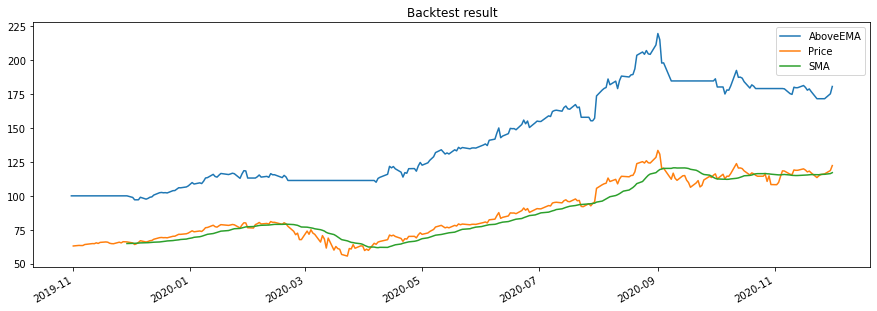

In [17]:
bt_result.plot(title='Backtest result')
plt.plot(price_data, label='Price')
plt.plot(sma, label='SMA')
plt.legend()
plt.show()

The line chart shows how much the beginning capital balance increases over time from a baseline of 100. 

**Note the flat line areas** indicate periods when we don't have any positions, so the trading account balance does not change. Overall, **the strategy is profitable** based on the backtest performed on the historical data.

# Trend-following strategies
Let's build and backtest a trend-following strategy!

## Two types of trading strategies
The two most popular types of trading strategies are trend following and mean reversion. Trend following, also known as a momentum strategy, bets that the price trend will continue in the same direction. You implemented a simple trend-following strategy in the previous lesson. When the price rises above its moving average, enter a long position to bet the price will continue to rise. Traders commonly use trend indicators such as moving averages, ADX, etc to construct trading signals for trend following strategies. Mean reversion strategies, conversely, bet that when the market reaches an overbought or oversold condition, the price tends to reverse back towards the mean. We will learn more about them in the following lesson. Traders commonly use indicators such as RSI, Bollinger Bands, etc, to construct trading signals for mean-reversion strategies. Markets are constantly moving in and out of phases of trending and mean reversion. Therefore it's beneficial to develop strategies for both phases.

## MA crossover strategy
The philosophy of trend following strategy is: the trend is your friend. Let's look at a common example of a trend-following strategy called MA crossover, which involves two moving average indicators, one longer and one shorter. We will use the EMA for example. When the short-term EMA crosses above the long-term EMA, it is a long signal, as it suggests the price is picking up momentum. When the short-term EMA crosses below the long-term EMA, it's a short signal, as it suggests that the price is losing momentum.

## Calculate the indicators
First, let's calculate the indicators with the talib EMA function. Note we use to underscore frame to save the result as a pandas DataFrame.

## Construct the signal
We construct the signal by copying the EMA indicator DataFrame with the dot copy method. We set the signal value to 0 for the initial n periods that do not have enough data points for the EMA. Then, we define the signal. When the short-term EMA value is larger than the long-term EMA value, the signal is one indicating a long position; when short-term EMA is smaller than the long-term EMA, the signal is minus one indicating a short position. Note that shorting a stock essentially means betting the price will go down, and entails selling borrowed shares, and later buying them back at market price.

## Plot the signal
We can plot the signal with the price and EMA indicators together. First use bt merge to combine multiple DataFrames. It takes in several DataFrames and merges them into one based on the DataFrame index, in this case the Date. Then use the dot columns attribute of the DataFrame to rename the data columns and create a plot. Since the signal has a different scale from the price and EMA data, define secondary underscore y to the signal column to plot it on secondary y axis on the right. The chart gives a clear indication of where to take long or short positions.

## Define the strategy with the signal
Now we are ready to implement the signal in the strategy. In the previous lesson, we used algos SelectWhere to build the signal. Here the signal is not constructed directly from the price comparison, so we will use another way provided by bt. Call WeighTarget and pass the signal DataFrame. The signal value 1, minus 1 or 0 will dictate which period we will have long positions, short positions, or no positions.

## Backtest the signal based strategy
Once we have the strategy defined, create and run a backtest and see how it performs.

## Plot backtest results
Last, let's plot and review the backtest result. Overall the strategy is profitable based on the historical period backtested.